# Rossman Sales Analysis

## Aim:
- Understanding how to approach business related problems
- Solving business related problems
- Performing Exploratory Data Analysis
- Performing Data Vidualizations

### Files
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores

### Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store 

In [1]:
# https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet

In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas import datetime
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
# from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Importing data

In [3]:
train = pd.read_csv('input data/train.csv', parse_dates=True, low_memory=False, index_col='Date')
store = pd.read_csv('input data/store.csv', low_memory=False)

In [4]:
print(train.shape, '\n', store.shape)
train.head(5)

(1017209, 8) 
 (1115, 10)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

### Sales analysis 

In [6]:
train['SalePerCustomer'] = train['Sales'] / train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

- Average sales = $ 5774/day 

- Average customer visits = 635/day

- Average Sales/Customer = $ 9.50/customer/day

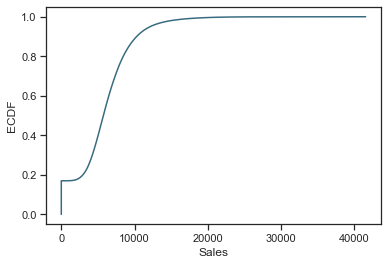

In [16]:
sns.set(style='ticks')
c = '#386B7F'

cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

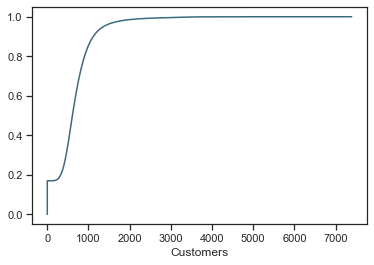

In [17]:
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

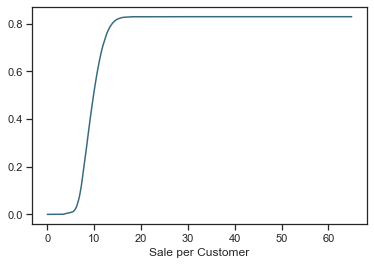

In [18]:
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

- Around 20%: No sales reported. 
- 80% of the times customers/day < 1000

From the dataset, days when the shop was closed/sales was zero, the data should be removed from the analysis.

In [35]:
# No sales and store closed
filt = (train['Open'] == 0) & (train['Sales'] == 0)
train[filt]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,NaN


In [37]:
# Store open and no sales
zero_sales = train[(train['Open'] != 0) & (train['Sales'] == 0)]
zero_sales.shape

(54, 13)

In [52]:
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]
train.shape

(844338, 13)

In [41]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [51]:
store[pd.isna(store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
